In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import word_tokenize
from nltk.tokenize import WhitespaceTokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import log_loss
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os
%matplotlib inline 
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
import re
import string
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.utils import shuffle
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import numpy as np
import itertools

In [2]:
# Read CSV Dataset Files
fakedf = pd.read_csv('./dataset/Fake.csv')
truedf = pd.read_csv('./dataset/True.csv')

# Create 'target' for fake and real news
fakedf['target'] = 'fake'
truedf['target'] = 'true'

# Concatenate both DataFrames into a single dataset containing both real and fake news 
NewsData = pd.concat([fakedf, truedf]).reset_index(drop = True)

# Shuffle the data to prevent overfitting and dataset memorization
NewsData = shuffle(NewsData)
NewsData = NewsData.reset_index(drop=True)

#  Adjust columns in NewsData
NewsData['news']=NewsData['title']+NewsData['text']
NewsData=NewsData.drop(['title', 'text'], axis=1)
NewsData['date'].value_counts()

# Make Dataset Smaller for Faster Run Time
NewsData_S  = NewsData[:750]

# Place independent features in X variable 
X = NewsData_S.drop('target',axis =1)

# Place 'target' values (True or False) in y variable
y = NewsData_S['target']

# Create a copy of the adjusted dataset
NewsData_Adjusted = NewsData_S.copy()

In [3]:
port_S = PorterStemmer()
array_= []

for i in range(0, len(NewsData_Adjusted)):
      text_adj = re.sub('[^a-zA-Z]', ' ', NewsData_Adjusted['news'][i])
      text_adj = re.sub('https?://\S+|www\.\S+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('<.*?>+', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('[%s]' % re.escape(string.punctuation), '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\n', '', NewsData_Adjusted['news'][i])
      text_adj = re.sub('\w*\d\w*', '', NewsData_Adjusted['news'][i])
      text_adj = text_adj.lower()
      text_adj = text_adj.split()
      text_adj = [port_S.stem(word) for word in text_adj if not word in stopwords.words('english')]
      text_adj = ' '.join(text_adj)
      array_.append(text_adj)

cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(array_).toarray()
X.shape 
y =NewsData_Adjusted['target']

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)

In [5]:
count_df = pd.DataFrame(X_train,columns = cv.get_feature_names_out())

In [6]:
def evaluate_classifier(classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues'):
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    
    # Evaluation of Results
    acc_score = accuracy_score(y_test, pred)
    percent_conv = acc_score * 100
    print("Acc: %0.2f%%" % percent_conv)
    
    cf_matrix = confusion_matrix(y_test, pred)
    sns.heatmap(cf_matrix, annot=True, cmap=heatmap_color)
    plt.show()

# MultinomialNB

Acc: 94.33%


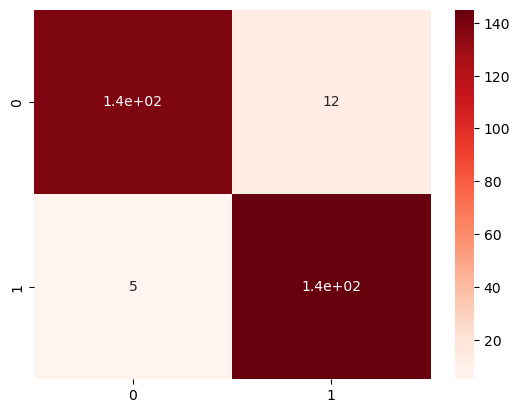

In [7]:
MultinomialNB_classifier = MultinomialNB()
evaluate_classifier(MultinomialNB_classifier, X_train, y_train, X_test, y_test, heatmap_color='Reds')

# kNN Classification

Acc: 62.00%


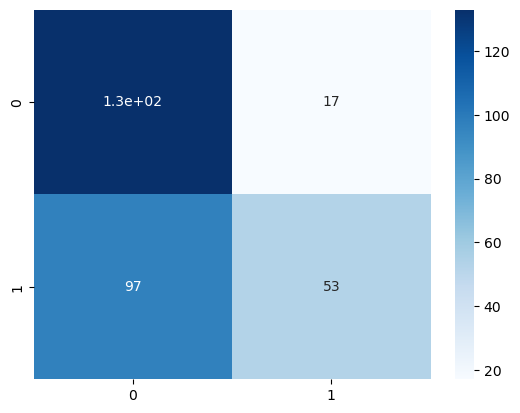

In [8]:
knn_classifier = KNeighborsClassifier()
evaluate_classifier(knn_classifier, X_train, y_train, X_test, y_test, heatmap_color='Blues')

# Logistic Regression

Acc: 95.00%


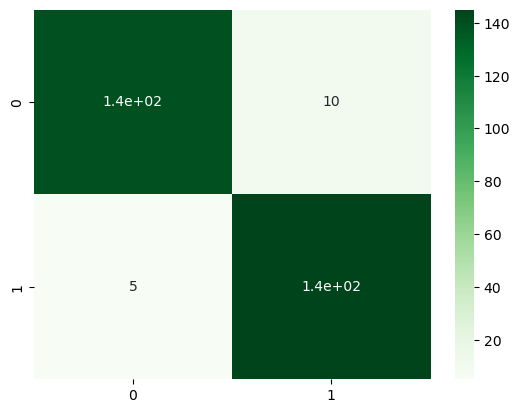

In [9]:
logreg_classifier = LogisticRegression()
evaluate_classifier(logreg_classifier, X_train, y_train, X_test, y_test, heatmap_color = "Greens")

# Random Forest Classifier

Acc: 98.67%


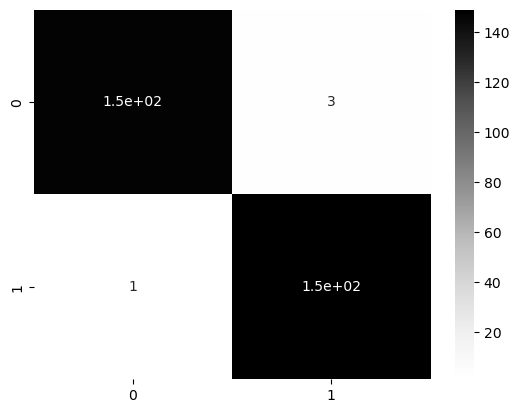

In [10]:
rfc = RandomForestClassifier(n_estimators = 600, bootstrap = True, random_state=8)
evaluate_classifier(rfc, X_train, y_train, X_test, y_test, heatmap_color = "Greys")

# Passive Agressive Classifier

Acc: 94.33%


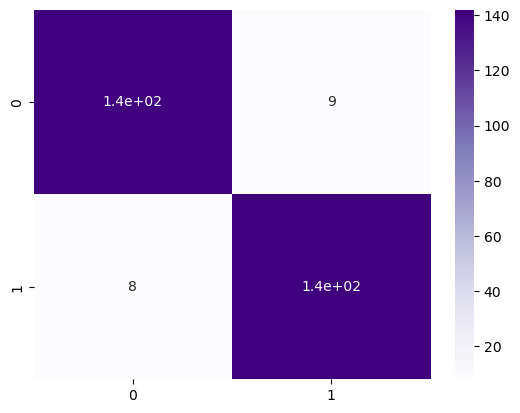

In [11]:
pac = PassiveAggressiveClassifier()
evaluate_classifier(pac, X_train, y_train, X_test, y_test, heatmap_color = "Purples")